## 1️⃣ Imports & Setup

In [1]:
import sys, os, warnings
warnings.filterwarnings("ignore")
sys.path.insert(0, os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.features import load_sales, filter_series, build_feature_frame
from src.models import train_xgb_reg, evaluate_predictions, recursive_forecast
from src.tsutils import train_valid_split_by_date


## 2️⃣ Load Dataset & Pick Series

In [2]:
CSV_PATH = "../data/store_item_demand.csv"
df_all = load_sales(CSV_PATH)
print(df_all.head())

STORE_ID = 1
ITEM_ID  = 1
series = filter_series(df_all, store=STORE_ID, item=ITEM_ID)
series.shape, series.head()

        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10


((1826, 4),
         date  store  item  sales
 0 2013-01-01      1     1     13
 1 2013-01-02      1     1     11
 2 2013-01-03      1     1     14
 3 2013-01-04      1     1     13
 4 2013-01-05      1     1     10)

## 3️⃣ Feature Engineering (calendar, lags, rolling stats)

In [3]:
df_feat = build_feature_frame(series)  # adds dow, week, month, year, lags (1,7,28), rolling means/stds (7,28)
df_feat.head()


,date,store,item,sales,dow,week,month,year,lag_1,lag_7,lag_28,rmean_7,rstd_7,rmean_28,rstd_28
0,2013-01-29,1,1,6,1,5,1,2013,11.0,7.0,13.0,10.428571,2.507133,10.714286,3.077483
1,2013-01-30,1,1,9,2,5,1,2013,6.0,9.0,11.0,10.285714,2.751623,10.464286,3.167920
2,2013-01-31,1,1,13,3,5,1,2013,9.0,8.0,14.0,10.285714,2.751623,10.392857,3.177925
3,2013-02-01,1,1,11,4,5,2,2013,13.0,14.0,13.0,11.000000,2.708013,10.357143,3.141294
4,2013-02-02,1,1,21,5,5,2,2013,11.0,12.0,10.0,10.571429,2.370453,10.285714,3.101459


## 4️⃣ Time-based Train/Validation Split

In [4]:
train_df, valid_df = train_valid_split_by_date(df_feat, date_col="date", valid_days=28)
target_col = "sales"
feature_cols = [c for c in df_feat.columns if c not in ["date", target_col]]

X_train, y_train = train_df[feature_cols], train_df[target_col]
X_valid, y_valid = valid_df[feature_cols], valid_df[target_col]

X_train.shape, X_valid.shape


((1770, 13), (28, 13))

## 5️⃣ Train XGBoost & Evaluate on Validation (last 28 days)

In [5]:
model = train_xgb_reg(X_train, y_train)
y_pred = model.predict(X_valid)
metrics = evaluate_predictions(y_valid, y_pred)
metrics


{'RMSE': 3.9607322383868335,
 'MAPE': 24.05720722403595,
 'sMAPE': 20.174783612104935}

## 6️⃣ Plot Actual vs Predicted (Validation)

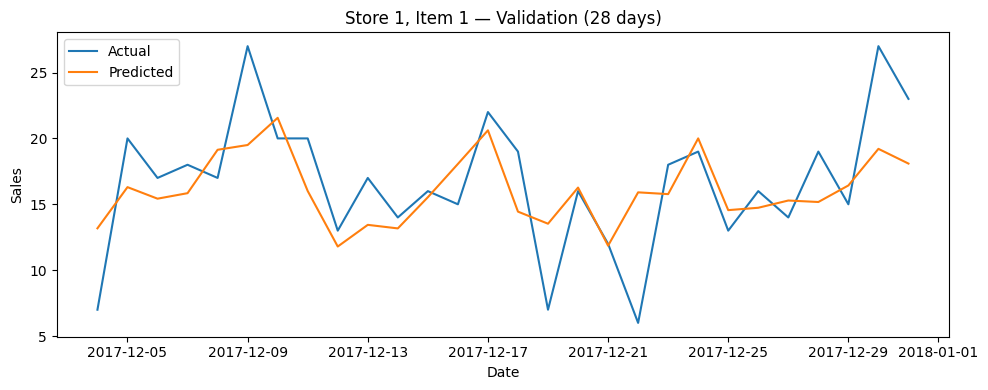

In [13]:
# Save the validation plot for the README
import os
os.makedirs("../artifacts", exist_ok=True)

plt.figure(figsize=(10,4))
plt.plot(valid_df["date"], y_valid.values, label="Actual")
plt.plot(valid_df["date"], y_pred, label="Predicted")
plt.title(f"Store {STORE_ID}, Item {ITEM_ID} — Validation (28 days)")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout()
plt.savefig("../artifacts/validation_plot.png", dpi=150, bbox_inches="tight")
plt.show()


## 7️⃣ 28-Day Forward Forecast (Recursive)

In [7]:
# Use the full series (no leakage): rebuild features using all history
from src.features import build_feature_frame

def feature_maker(df_raw):
    return build_feature_frame(df_raw)

future_df, preds = recursive_forecast(model, series, feature_maker, horizon=28, target_col="sales")
future_df.head()

,date,pred
0,2018-01-01,13.955994
1,2018-01-02,14.288024
2,2018-01-03,11.899548
3,2018-01-04,13.915421
4,2018-01-05,17.707293


## 8️⃣ Plot Forecast vs Recent History

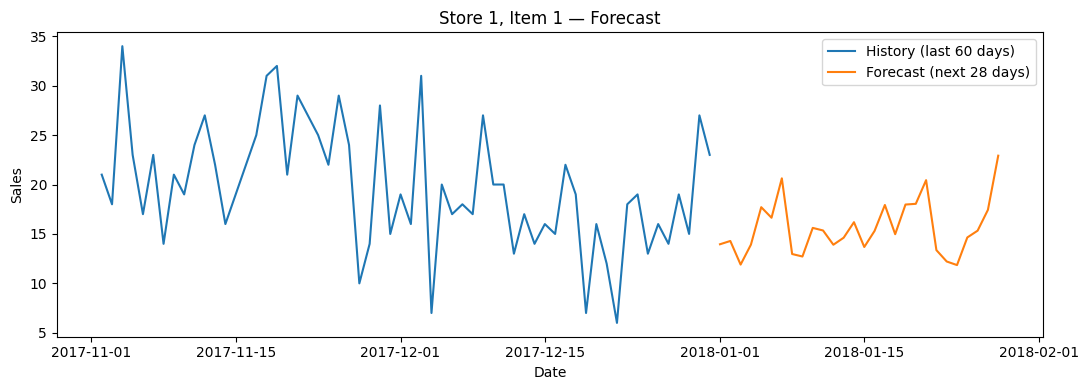

In [12]:
# Save the forecast plot for the README
plt.figure(figsize=(11,4))
recent = series.sort_values("date").tail(60)
plt.plot(recent["date"], recent["sales"], label="History (last 60 days)")
plt.plot(future_df["date"], future_df["pred"], label=f"Forecast (next {len(future_df)} days)")
plt.title(f"Store {STORE_ID}, Item {ITEM_ID} — Forecast")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout()
plt.savefig("../artifacts/forecast_plot.png", dpi=150, bbox_inches="tight")
plt.show()

## 9️⃣ Save Model & Metadata

In [9]:
import joblib, json, os
os.makedirs("../artifacts", exist_ok=True)
joblib.dump(model, f"../artifacts/model_store{STORE_ID}_item{ITEM_ID}.pkl")
meta = {
    "store": STORE_ID, "item": ITEM_ID,
    "feature_cols": feature_cols,
    "train_end": str(train_df["date"].max()),
    "valid_range": [str(valid_df["date"].min()), str(valid_df["date"].max())],
    "metrics": metrics
}
with open(f"../artifacts/meta_store{STORE_ID}_item{ITEM_ID}.json","w") as f:
    json.dump(meta, f, indent=2)
"Artifacts saved."


'Artifacts saved.'